# DSC478 Movie Recommender System
## Objective
#### For the final project, our team has built a movie recommender system application that is capable of suggesting movies to users based on rating or genre. 
#### Rating based: We are using KNN to search closest K neighbors (users) from the dataset that has rating for the movie, then recommend rating for a user. <br>Genre based: We are using TF-IDF to recommend the best movie matches based on genre.
## Dataset
#### We are using the MOVIELENS DATA SET that consists of: <br>100,000 ratings (1-5) from 943 users on 1682 movies. <br>Each user has rated at least 20 movies. <br>Simple demographic info for the users (age, gender, occupation, zip)
#### The data will be merged and transformed in order to perform the useful tasks in the application.
## Recommender System Breakdown
### Collaborative Filtering
#### Using cosine similarity, recommendations are given to a user based on the relationship between user A and B movie ratings. Collaborative filtering basis these relationships on the ratings that the user has submitted after signing up in the system. Then, accurately recommends movies based other users ratings to predict what movies the new user would enjoy. 
### Content Based
#### The contents of an item such as a movie is described using either a brief written summary or genre. Since the dataset that we used had only the genre attribute availble, we decided to use TF-IDF to recommend movies to users.
### Outside Sources Used:
#### https://www.analyticsvidhya.com/blog/2020/11/create-your-own-movie-movie-recommendation-system/ <br> https://www.datacamp.com/community/tutorials/recommender-systems-python



In [4]:
# cell for installing libraries.
!pip install seaborn

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [6]:
DATA_PATH = 'movielens/Movielens-02/'

In order to create the Data matrix for our analysis, the following steps were made to preprocess the data:

In [7]:
columns = ['user id', 'item id', 'rating', 'timestamp']#creating the column names
udata_df = pd.read_csv(DATA_PATH + 'u.data', delimiter='\t', names=columns)

In [8]:
udata_df.head()

,user id,item id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [9]:
columns = ['item id', 'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama',
           'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
uitem_df = pd.read_csv(DATA_PATH + 'u.item', sep="|", names=columns, encoding='latin-1')

In [10]:
uitem_df.head()

,item id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [11]:
# Basic statistics for data in terms of rating
udata_df['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

<AxesSubplot:xlabel='Rating', ylabel='Frequency'>

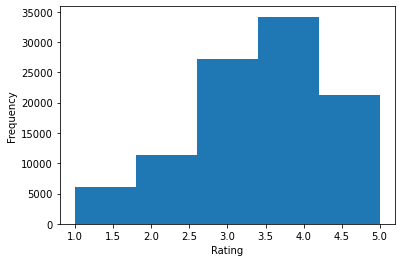

In [12]:
# Distribution of ratings in the form of a histogram
ratings_hist = udata_df["rating"].plot(kind="hist", bins=5)
ratings_hist.set_xlabel("Rating")
ratings_hist

<AxesSubplot:xlabel='Rating'>

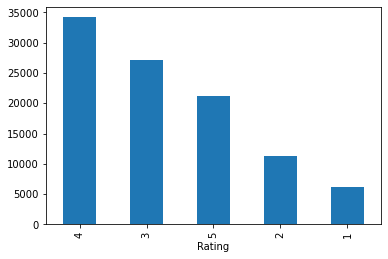

In [13]:
# Bar graph to show distribution of ratings
ratings_bar = udata_df['rating'].value_counts().plot(kind='bar')
ratings_bar.set_xlabel("Rating")
ratings_bar

In [14]:
movies_drop = uitem_df.drop(['release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama',
           'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'], axis=1)
movies_drop.head()

,item id,movie title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [15]:
data_drop = udata_df.drop(['timestamp'],axis=1)
data_drop.head()

,user id,item id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [16]:
# Merged data on item id and movie id
merged = pd.merge(left=data_drop, right=movies_drop, left_on='item id', right_on='item id')
merged.head()

,user id,item id,rating,movie title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


In [17]:
# Sort by user id
user_sort = merged.sort_values(by=['user id'])
user_sort.head()

,user id,item id,rating,movie title
43606,1,12,5,"Usual Suspects, The (1995)"
79998,1,254,1,Batman & Robin (1997)
35906,1,189,3,"Grand Day Out, A (1992)"
69127,1,87,5,Searching for Bobby Fischer (1993)
51383,1,187,4,"Godfather: Part II, The (1974)"


In [18]:
# Creating base matrix of 943x1682 of all zeros
matrix = pd.DataFrame(np.zeros((944,1683),dtype=int))
matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Change first column to represent user id
matrix = matrix.rename({0:'user_id'}, axis='columns')
matrix.head()

,user_id,1,2,3,4,5,6,7,8,9,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Change values to user id
for i in range(944):
    matrix.at[i,'user_id'] = i
matrix.head()

,user_id,1,2,3,4,5,6,7,8,9,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Populate matrix by putting rating based on movie and user
for index, row in merged.iterrows():
    user = row['user id']
    movie = row['item id']
    rating = row['rating']
    matrix.at[user,movie] = rating

In [22]:
# Displaying matrix with values filled. There are no values in the first row because there is no user_id value of 0
matrix.head()

,user_id,1,2,3,4,5,6,7,8,9,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,5,3,4,3,3,5,4,1,5,...,0,0,0,0,0,0,0,0,0,0
2,2,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# To get specific rating need to get column then index that for specific row below example is for user 181 and movie 1325 
x = matrix[1325]
x[181]

1

In [24]:
# Creating the matrix as a .csv file for analysis use
# matrix.to_csv('data_matrix.csv', index=False)

#### Visualizing the ratings distribution we can see that majority of users are generous raters that give 3 or above rating with 4 being the highest in density. 

C:\Users\poyan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rating', ylabel='Density'>

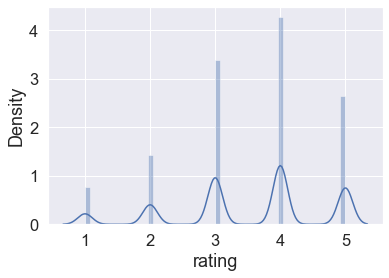

In [25]:
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
sns.distplot(udata_df['rating'].fillna(udata_df['rating'].median()))

#### Merging data and item dataframes on item id to include ratings.

In [42]:
new_avg_rating = udata_df.groupby(['item id'])['rating'].mean().reset_index()
merged_data_item = new_avg_rating.merge(uitem_df, on='item id')
movies_w_genre = merged_data_item.drop(['release date', 'video release date', 'IMDb URL'], axis=1)

In [43]:
movies_w_genre

,item id,rating,movie title,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,3.878319,Toy Story (1995),0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,3.206107,GoldenEye (1995),0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,3.033333,Four Rooms (1995),0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,3.550239,Get Shorty (1995),0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,3.302326,Copycat (1995),0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,1.000000,Mat' i syn (1997),0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,3.000000,B. Monkey (1998),0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,2.000000,Sliding Doors (1998),0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,3.000000,You So Crazy (1994),0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Changing binary genre values to strings in order to be used with TFxIDF

In [44]:
movies_w_genre['unknown'] = movies_w_genre['unknown'].map({1:"unknown" ,0:''}) 
movies_w_genre['Action'] = movies_w_genre['Action'].map({1:"Action" ,0:''}) 
movies_w_genre['Adventure'] = movies_w_genre['Adventure'].map({1:"Adventure" ,0:''}) 
movies_w_genre['Animation'] = movies_w_genre['Animation'].map({1:"Animation" ,0:''}) 
movies_w_genre['Childrens'] = movies_w_genre['Childrens'].map({1:"Childrens" ,0:''}) 
movies_w_genre['Comedy'] = movies_w_genre['Comedy'].map({1:"Comedy" ,0:''}) 
movies_w_genre['Crime'] = movies_w_genre['Crime'].map({1:"Crime" ,0:''}) 
movies_w_genre['Documentary'] = movies_w_genre['Documentary'].map({1:"Documentary" ,0:''}) 
movies_w_genre['Drama'] = movies_w_genre['Drama'].map({1:"Drama" ,0:''}) 
movies_w_genre['Fantasy'] = movies_w_genre['Fantasy'].map({1:"Fantasy" ,0:''}) 
movies_w_genre['Film-Noir'] = movies_w_genre['Film-Noir'].map({1:"Film-Noir" ,0:''}) 
movies_w_genre['Horror'] = movies_w_genre['Horror'].map({1:"Horror" ,0:''}) 
movies_w_genre['Musical'] = movies_w_genre['Musical'].map({1:"Musical" ,0:''}) 
movies_w_genre['Mystery'] = movies_w_genre['Mystery'].map({1:"Mystery" ,0:''}) 
movies_w_genre['Romance'] = movies_w_genre['Romance'].map({1:"Romance" ,0:''}) 
movies_w_genre['Sci-Fi'] = movies_w_genre['Sci-Fi'].map({1:"Sci-Fi" ,0:''}) 
movies_w_genre['Thriller'] = movies_w_genre['Thriller'].map({1:"Thriller" ,0:''}) 
movies_w_genre['War'] = movies_w_genre['War'].map({1:"War" ,0:''}) 
movies_w_genre['Western'] = movies_w_genre['Western'].map({1:"Western" ,0:''}) 

In [45]:
movies_w_genre

,item id,rating,movie title,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,3.878319,Toy Story (1995),,,,Animation,Childrens,Comedy,,...,,,,,,,,,,
1,2,3.206107,GoldenEye (1995),,Action,Adventure,,,,,...,,,,,,,,Thriller,,
2,3,3.033333,Four Rooms (1995),,,,,,,,...,,,,,,,,Thriller,,
3,4,3.550239,Get Shorty (1995),,Action,,,,Comedy,,...,,,,,,,,,,
4,5,3.302326,Copycat (1995),,,,,,,Crime,...,,,,,,,,Thriller,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,1.000000,Mat' i syn (1997),,,,,,,,...,,,,,,,,,,
1678,1679,3.000000,B. Monkey (1998),,,,,,,,...,,,,,,Romance,,Thriller,,
1679,1680,2.000000,Sliding Doors (1998),,,,,,,,...,,,,,,Romance,,,,
1680,1681,3.000000,You So Crazy (1994),,,,,,Comedy,,...,,,,,,,,,,


## Concatenating rows into one dedicated 'genre' column

In [46]:
movies_w_genre['genre'] = movies_w_genre["unknown"] +" "+ movies_w_genre["Action"] +" "+ movies_w_genre["Adventure"] +" "+ movies_w_genre["Animation"] +" "+ movies_w_genre["Childrens"] +" "+ movies_w_genre["Comedy"] +" "+ movies_w_genre["Crime"] +" "+ movies_w_genre["Documentary"] +" "+ movies_w_genre["Drama"] +" "+ movies_w_genre["Fantasy"] +" "+ movies_w_genre["Film-Noir"] +" "+ movies_w_genre["Horror"] +" "+ movies_w_genre["Musical"] +" "+ movies_w_genre["Mystery"] +" "+ movies_w_genre["Romance"] +" "+ movies_w_genre["Sci-Fi"] +" "+ movies_w_genre["Thriller"] +" "+ movies_w_genre["War"] +" "+ movies_w_genre["Western"]

## Dropping unwanted columns

In [48]:
movies_w_genre = movies_w_genre.drop(['unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'], axis=1)

In [49]:
movies_w_genre

,item id,rating,movie title,genre
0,1,3.878319,Toy Story (1995),Animation Childrens Comedy
1,2,3.206107,GoldenEye (1995),Action Adventure Thriller
2,3,3.033333,Four Rooms (1995),Thriller
3,4,3.550239,Get Shorty (1995),Action Comedy Drama
4,5,3.302326,Copycat (1995),Crime Drama Thriller
...,...,...,...,...
1677,1678,1.000000,Mat' i syn (1997),Drama
1678,1679,3.000000,B. Monkey (1998),Romance Thriller
1679,1680,2.000000,Sliding Doors (1998),Drama Romance
1680,1681,3.000000,You So Crazy (1994),Comedy


### Exporting modified dataset to file.

In [ ]:
#movies_w_genre.to_csv(DATA_PATH + 'movies_w_genre3.csv', index=False)

#### Using TF-IDF to find recommendation based on genre.

In [82]:
df_movie_genre = pd.read_csv(DATA_PATH + 'movies_w_genre.csv', header=0)

In [113]:
#Recommendation based on similar genre 
# class Genre_Based:
#     def __init__(self, movie_title, dataset):
#         self.movie_title = movie_title
#         self.dataset = dataset

#         ###transforming data to be used with cos sim in genre recommender method
#         #vectorizer to be used when creating the tfidf matrix
#     def tfidf_prep(self):
#         tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')
#         #creating the tfidf matrix
#         tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(self.dataset['genre'])
#         #computing the cosine similarity
#         cosine_sim_movies = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)
#         return cosine_sim_movies

#     ### recommend movies based on similar genres
#     def genre_recommender(self):
#         #computing the cosine similarity and storing locally
#         cosine_sim_movies = self.tfidf_prep()
#         #variable to store index of movie that the user has specified
#         movie_index = self.dataset.loc[self.dataset['movie title'].isin([self.movie_title])]
#         movie_index = movie_index.index
#         #computing the similarity score and then sorting based on the score
#         movies_sim_scores = list(enumerate(cosine_sim_movies[movie_index][0]))
#         movies_sim_scores = sorted(movies_sim_scores, key=lambda x: x[1], reverse=True)
#         #fetch score of the most similar movies and get their movie index to be used when printing out result to user
#         movies_sim_scores = movies_sim_scores[1:21]
#         movie_indices = [i[0] for i in movies_sim_scores]

#         #outputting results sorted by ratings
#         return print(self.dataset[['movie title','genre','rating']].iloc[movie_indices])


#Recommendation based on similar genre 
class Genre:
    def __init__(self, sim_metric="cosine"):
        self.tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')

    def fit(self, dataset):
        self.dataset = dataset
        #creating the tfidf matrix
        tfidf_movies_genres_matrix = self.tfidf_movies_genres.fit_transform(self.dataset['genre'])
        print("TFxIDF:\n", tfidf_movies_genres_matrix)
        #computing the cosine similarity
        self.cosine_sim_movies = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)
        print("\nCosine Similarity Matrix:\n", self.cosine_sim_movies)

    def predict(self, movie_title, K):
        self.movie_title = movie_title
        #variable to store index of movie that the user has specified
        #movie_index = self.dataset.loc[self.dataset['movie title'].isin([self.movie_title])]
        movie_index = self.dataset.loc[self.dataset['movie title'] == self.movie_title]
        movie_index = movie_index.index
        #computing the similarity score and then sorting based on the score
        movies_sim_scores = list(enumerate(self.cosine_sim_movies[movie_index][0]))
        movies_sim_scores = sorted(movies_sim_scores, key=lambda x: x[1], reverse=True)
        #fetch score of the most similar movies and get their movie index to be used when printing out result to user
        movies_sim_scores = movies_sim_scores[1:K+1]
        movie_indices = [i[0] for i in movies_sim_scores]

        #outputting results sorted by ratings
        return self.dataset[['movie title','genre','rating']].iloc[movie_indices].sort_values('rating', ascending=False)
    

In [114]:
##For testing genre based
# genre_test = Genre_Based("Toy Story (1995)", df_movie_genre)
# genre_test.genre_recommender()

genre = Genre()
genre.fit(df_movie_genre)


TFxIDF:
   (0, 4)	0.3494185741533606
  (0, 3)	0.5738720889486926
  (0, 2)	0.7406601687429238
  (1, 15)	0.5367670572828946
  (1, 1)	0.65097023928266
  (1, 0)	0.5367670572828946
  (2, 15)	1.0
  (3, 7)	0.45125861978714765
  (3, 0)	0.7106515752311352
  (3, 4)	0.5397592025054364
  (4, 5)	0.7355039968269306
  (4, 7)	0.36318584666261283
  (4, 15)	0.5719527178321399
  (5, 7)	1.0
  (6, 14)	0.9001177228648021
  (6, 7)	0.43564674334222164
  (7, 7)	0.3987320343118861
  (7, 4)	0.4769311330940778
  (7, 3)	0.7832939799967215
  (8, 7)	1.0
  (9, 17)	0.9141709429231192
  (9, 7)	0.4053288629188098
  (10, 5)	0.7894073202586381
  (10, 15)	0.6138697603906517
  (11, 5)	0.7894073202586381
  :	:
  (1663, 4)	1.0
  (1664, 7)	1.0
  (1665, 7)	1.0
  (1666, 7)	1.0
  (1667, 4)	1.0
  (1668, 12)	0.7190099097449649
  (1668, 5)	0.6231665274318257
  (1668, 7)	0.3077145248068365
  (1669, 15)	0.7963435397823456
  (1669, 4)	0.6048445805716736
  (1670, 7)	1.0
  (1671, 7)	1.0
  (1672, 15)	0.7071067811865476
  (1672, 0)	0.70710

In [116]:
movies = genre.predict("Get Shorty (1995)", 5)
print(movies)

                             movie title                                genre  \
73   Faster Pussycat! Kill! Kill! (1965)   Action    Comedy   Drama             
390              Last Action Hero (1993)        Action    Comedy                
875                   Money Talks (1997)        Action    Comedy                
387         Beverly Hills Cop III (1994)        Action    Comedy                
455           Beverly Hills Ninja (1997)        Action    Comedy                

       rating  
73   3.000000  
390  2.745763  
875  2.702128  
387  2.392857  
455  2.312500  


#### Using KNN to find closest users based on rating. 

In [30]:
def recommend_movie(self, movie_data, knn_model, num_recommendations):
    neighbors = knn_model.kneighbors(movie_data, n_neighbors = num_recommendations, return_distance = True)
    return neighbors

def __init__(self, dataset, K, W, M): # instance, K, Weighted voting, Metric 
    self.cosine_knn = NearestNeighbors(metric="cosine", algorithm = "brute", n_neighbors = K, n_jobs = 1)
    self.cosine_knn.fit(dataset)
  
def neighbor(self, X, K):
    return self.recommend_movie(X, self.cosine_knn, K)
    #return (0, [0])

def predict(self, X, K):
    distances, indices = self.neighbor(X, K)
    return 0.0